In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline


from lvmdap.dap_tools import list_columns,read_DAP_file,map_plot_DAP
from lvmdap.dap_tools import plot_spectra,plot_spec,read_tab_EL
from lvmdap.dap_tools import read_coeffs_RSP
from matplotlib import use as mpl_use
from astropy.io import fits, ascii
from astropy.table import Table, join,QTable
from astropy.table import unique as tab_unique
from astropy.cosmology import WMAP9 as cosmo
#mpl_use('Agg')

%matplotlib inline
from matplotlib import rcParams as rc
rc.update({'font.size': 19,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 19,\
           'ytick.labelsize' : 19,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })



In [2]:
from lvmdap.dap_tools import PDF_plot, get_den_levels, PDF_plot_cl, PDF_get 
from lvmdap.dap_tools import read_coeffs_RSP, DAP_extract_coeffs

In [3]:
DIR_DAP = 'output_dap'
#dap_file='Helix_DR19.dap.fits.gz'
dap_file='Helix_DR19_new.dap.fits.gz'

dap_file=f'{DIR_DAP}/{dap_file}'
tab_DAP=read_DAP_file(dap_file,verbose=True)
tab_DAP['ifu'] = tab_DAP['fiberid'] // 325

---- ALL Table Columns -----
-------------------------------
|        PT                   |
-------------------------------
id        dec       fiberid   
ra        mask      exposure  
----------------------------------
|        RSP                      |
----------------------------------
id             alpha          flux_st        Fe_MW          
MIN_CHISQ      e_alpha        redshift_st    e_Fe_MW        
Teff           Av_st          med_flux_st    alpha_MW       
e_Teff         e_Av_st        e_med_flux_st  e_alpha_MW     
Log_g          z_st           Teff_MW        vel_st         
e_Log_g        e_z_st         e_Teff_MW      log_ML         
Fe             disp_st        Log_g_MW       log_Mass       
e_Fe           e_disp_st      e_Log_g_MW                    
----------------------------------
|        PE_ord                   |
----------------------------------
id                 vel_pe_4340.49     e_disp_pe_6300.3   disp_pe_6716.44    
flux_pe_3726.03    e_vel_pe_4340.49 

In [4]:
DAP_hdu=fits.open(dap_file)
#DAP_hdu.info()
tab_DAP_info = Table(DAP_hdu['info'].data)
tab_DAP_info

param,value
str24,str74
lvm_file,data/lvmSFrame-00004297.fits
label,Helix_DR19_new
config_yaml,lvm-dap_SD_fast_SN20_ofelia_nosky_hack_cl.yaml
debug,False
lvmsim,False
in_rss,False
plot,0
output_path,/disk-a/sanchez/home/sda2/articulos/LVM/Helix/analysis/output_dap/
lvmdap_dir,/home/sanchez/sda2/code/python/lvmdap


In [5]:
#
# RSP used during the fitting
#
rsp_file='/disk-a/sanchez/LVM/LVM/ver_231113/mstar-stlib-cl-108.fits.gz'
rsp_hdu=fits.open(rsp_file)
rsp_hdu.info()

Filename: /disk-a/sanchez/LVM/LVM/ver_231113/mstar-stlib-cl-108.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SPECTRA       1 PrimaryHDU      13   (6351, 108)   float32   
  1  PARAMETERS    1 BinTableHDU     29   108R x 10C   [D, E, E, E, E, E, E, E, E, E]   
  2  ERROR         1 ImageHDU        14   (6351, 108)   float32   
  3  ORG_PARAM     1 BinTableHDU     31   1235R x 11C   [K, E, E, E, E, E, E, E, E, E, J]   
  4  PDF_TEFF_LOGG    1 ImageHDU        17   (100, 100, 108)   float64   
  5  PDF_TEFF_MET    1 ImageHDU        17   (100, 100, 108)   float64   
  6  PDF_TEFF_ALPHAM    1 ImageHDU        17   (100, 100, 108)   float64   
  7  PDF_MET_ALPHAM    1 ImageHDU        17   (100, 100, 108)   float64   
  8  PDF_MET_LOGG    1 ImageHDU        17   (100, 100, 108)   float64   
  9  PDF_LOGG_MET    1 ImageHDU        17   (100, 100, 108)   float64   


In [6]:
#
# Full stellar library, prior to the clustering based on the observational parameters
#
in_file="/disk-a/sanchez/LVM/LVM/ver_231113/mstar-stlib-n1235-SN5.fits.gz"
hdu_in=fits.open(in_file)
tab_in=Table(hdu_in[1].data)
#tab_in['TEFF']=np.log10(tab_in['TEFF'])
#tab_in.columns
#plt.scatter(tab_in['TEFF'],tab_in['LOGG'])

In [7]:
SN_st = tab_DAP['med_flux_st']/tab_DAP['e_med_flux_st']
mask_SN = SN_st > 5
tab_DAP['SN_st'] = SN_st
tab_DAP_st = tab_DAP[mask_SN]
tab_coeffs = DAP_extract_coeffs(tab_DAP_st)

In [8]:
#
# Identify which fibers have sufficient S/N to generate a reliable RSP
# analysis
print(f'fibid: {np.unique(tab_coeffs["id_fib"])}')

fibid: id_fib
------
    49
   224
   244
   439
   460
   519
   589
   819
   861
   888
   940
   945
   975
   990
  1082
  1115
  1144
  1246
  1558
  1648
  1706
  1808


In [9]:
tab_DAP_st[0:3]

<Table length=3>
    id            ra                 dec         ...  ifu        SN_st       
   str9        float64             float64       ... int64      float64      
--------- ------------------ ------------------- ... ----- ------------------
4297.1082 337.35625730138355  -20.95173144306547 ...     3 28.001814093819657
4297.1115  337.3761429656673 -20.982208018169562 ...     3 12.788805670220867
4297.1144  337.2992377886743 -20.963262501206273 ...     3 36.739232090580124

0.15 0.15
0.15 0.45
0.45 0.15
0.45 0.45


/tmp/ipykernel_112532/3131735075.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


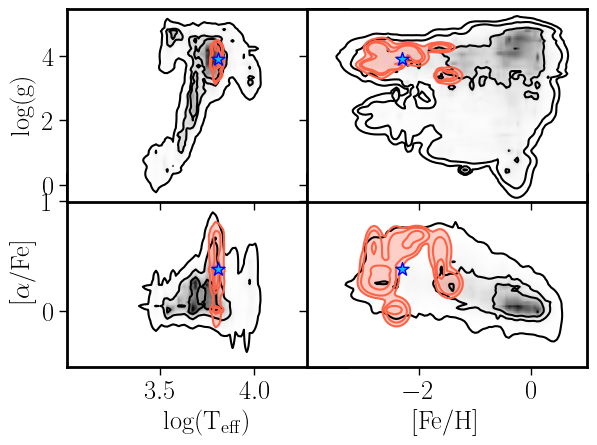

In [10]:

# n_fib=49
# n_fib=1808
n_fib=244




fig=plt.figure(figsize=(8,5.5))
left=[0.15,0.45]
width=[0.35,0.35]
axLS=[]
for x in left:
    for y in left:
        print(x,y)
        axLS.append(fig.add_axes([x, y, 0.35, 0.35]))

axLS[1].set_xticklabels([])
axLS[2].set_yticklabels([])
axLS[3].set_xticklabels([])
axLS[3].set_yticklabels([])
#conts=[0.95,0.65,0.40,0.0]
conts=[0.99,0.65,0.35,0.0]
#conts=[0.85,0.40,0.0]



hdu_now=rsp_hdu['PDF_TEFF_LOGG']
xlabel=r'log(T$_{\rm eff}$)'
ylabel=r'log(g)'
PDF_plot(ax=axLS[1],hdu_now=hdu_now,xlabel='',ylabel=ylabel,\
             n_fib=n_fib,tab_coeffs=tab_coeffs,\
             conts=conts)  

hdu_now=rsp_hdu['PDF_TEFF_ALPHAM']
xlabel=r'log(T$_{\rm eff}$)'
ylabel=r'[$\alpha$/Fe]'
PDF_plot(ax=axLS[0],hdu_now=hdu_now,xlabel=xlabel,ylabel=ylabel,\
             n_fib=n_fib,tab_coeffs=tab_coeffs,\
             conts=conts)  


hdu_now=rsp_hdu['PDF_MET_ALPHAM']
xlabel=r'[Fe/H]'
ylabel=r'[$\alpha$/Fe]'

PDF_plot(ax=axLS[2],hdu_now=hdu_now,xlabel=xlabel,ylabel='',\
             n_fib=n_fib,tab_coeffs=tab_coeffs,\
             conts=conts)  

hdu_now=rsp_hdu['PDF_MET_LOGG']
xlabel=r'[Fe/H]'
ylabel=r'log(g)'

PDF_plot(ax=axLS[3],hdu_now=hdu_now,xlabel='',ylabel='',\
             n_fib=n_fib,tab_coeffs=tab_coeffs,\
             conts=conts)  

axLS[0].set_xlim(3.01,4.49)
axLS[1].set_xlim(3.01,4.49)

axLS[2].set_xlim(-3.99,0.99)
axLS[3].set_xlim(-3.99,0.99)

color='deepskyblue'
ecolor='blue'
size=100

mask_id = tab_DAP_st['fiberid'] == n_fib
axLS[1].scatter(np.log10(tab_DAP_st['Teff'][mask_id]),tab_DAP_st['Log_g'][mask_id],\
                color=color,zorder=1000,marker='*',s=size,edgecolor=ecolor)
axLS[0].scatter(np.log10(tab_DAP_st['Teff'][mask_id]),tab_DAP_st['alpha'][mask_id],\
                color=color,zorder=1000,marker='*',s=size,edgecolor=ecolor)
axLS[2].scatter(tab_DAP_st['Fe'][mask_id],tab_DAP_st['alpha'][mask_id],\
                color=color,zorder=1000,marker='*',s=size,edgecolor=ecolor)
axLS[3].scatter(tab_DAP_st['Fe'][mask_id],tab_DAP_st['Log_g'][mask_id],\
                color=color,zorder=1000,marker='*',s=size,edgecolor=ecolor)

#axLS[1].scatter(tab_in['TEFF'],tab_in['LOGG'],color='green')
#print(tab_in['TEFF'][n_fib],tab_in['LOGG'][n_fib])
figname=f'PDF_rsp_Helix_{n_fib}'
fig.tight_layout()
fig.savefig('figs/'+figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

In [11]:
tab_coeffs[(tab_coeffs['id_fib'] == n_fib) & (tab_coeffs['COEFF'] > 0)]

id,TEFF,LOGG,META,ALPHAM,COEFF,Min.Coeff,log(M/L),AV,N.Coeff,Err.Coeff,rsp,id_fib
str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
4297.244,3.8093,3.9229,-2.3084,0.3809,1.0,0.0,14.638,0.0,1.0,0.0,76,244


In [12]:
tab_DAP_st['Teff','Log_g','Fe','alpha'][mask_id]

Teff,Log_g,Fe,alpha
float64,float64,float64,float64
6445.587584740916,3.9228765964508057,-2.3084418773651123,0.3808528780937195


In [16]:
# Group by 'rsp' and calculate the mean for each group
grouped_data = {}
for col in tab_coeffs.colnames:
    if col in ['rsp', 'id']:  # Exclude non-numeric columns like 'id'
        grouped_data[col] = []
    else:
        grouped_data[col] = []

unique_rsp = set(tab_coeffs['rsp'])
for rsp_value in unique_rsp:
    mask = tab_coeffs['rsp'] == rsp_value
    grouped_data['rsp'].append(rsp_value)
    for col in tab_coeffs.colnames:
        if col not in ['rsp', 'id']:  # Exclude non-numeric columns like 'id'
            grouped_data[col].append(tab_coeffs[col][mask].mean())
        elif col == 'id':  # For 'id', concatenate unique values as strings
            grouped_data[col].append(','.join(tab_coeffs[col][mask]))

# Create a new table with the averaged data
output_table = Table(grouped_data)
output_table['id'] = 1
output_table['id_fib'] = 1

In [17]:
print(len(output_table))

108


In [18]:
rc.update({'font.size': 19,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 19,\
           'ytick.labelsize' : 19,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })

0.15 0.15
0.15 0.45
0.45 0.15
0.45 0.45


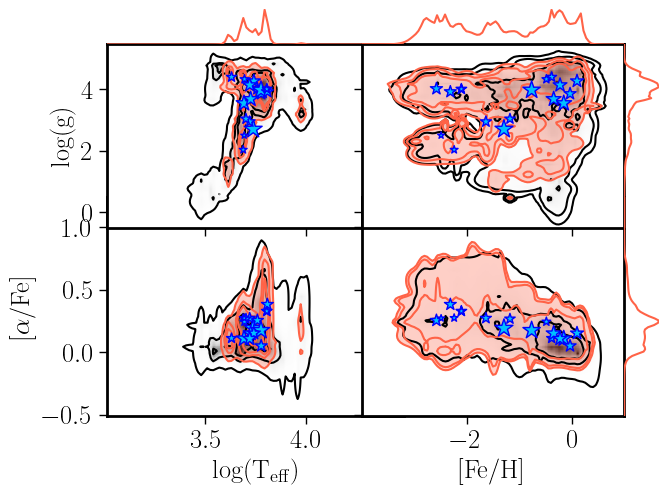

In [19]:

# n_fib=49
# n_fib=1808
n_fib=1
#n_fib=1808





fig=plt.figure(figsize=(8.5,6.25))
left=[0.15,0.45]
width=[0.35,0.35]
axLS=[]
for x in left:
    for y in left:
        print(x,y)
        axLS.append(fig.add_axes([x, y, 0.35, 0.35]))

axLS[1].set_xticklabels([])
axLS[2].set_yticklabels([])
axLS[3].set_xticklabels([])
axLS[3].set_yticklabels([])
#conts=[0.95,0.65,0.40,0.0]
#
# 
#conts=[0.99,0.65,0.35,0.0]
conts=[0.95,0.0]





hdu_now=rsp_hdu['PDF_TEFF_LOGG']
xlabel=r'log(T$_{\rm eff}$)'
ylabel=r'log(g)'
den_map_few = PDF_plot(ax=axLS[1],hdu_now=hdu_now,xlabel='',ylabel=ylabel,\
             n_fib=n_fib,tab_coeffs=output_table,\
             conts=conts, pXhist=True)  


hdu_now=rsp_hdu['PDF_TEFF_ALPHAM']
xlabel=r'log(T$_{\rm eff}$)'
ylabel=r'[$\alpha$/Fe]'
PDF_plot(ax=axLS[0],hdu_now=hdu_now,xlabel=xlabel,ylabel=ylabel,\
             n_fib=n_fib,tab_coeffs=output_table,\
             conts=conts)  


hdu_now=rsp_hdu['PDF_MET_ALPHAM']
xlabel=r'[Fe/H]'
ylabel=r'[$\alpha$/Fe]'

PDF_plot(ax=axLS[2],hdu_now=hdu_now,xlabel=xlabel,ylabel='',\
             n_fib=n_fib,tab_coeffs=output_table,\
             conts=conts,pYhist=True)  

hdu_now=rsp_hdu['PDF_MET_LOGG']
xlabel=r'[Fe/H]'
ylabel=r'log(g)'

PDF_plot(ax=axLS[3],hdu_now=hdu_now,xlabel='',ylabel='',\
             n_fib=n_fib,tab_coeffs=output_table,\
             conts=conts,pXhist=True,pYhist=True)  

axLS[0].set_xlim(3.01,4.49)
axLS[1].set_xlim(3.01,4.49)

axLS[2].set_xlim(-3.99,0.99)
axLS[3].set_xlim(-3.99,0.99)

color='deepskyblue'
ecolor='blue'
size=100
size = (tab_DAP_st['SN_st'])*5
mask_id = tab_DAP_st['fiberid'] == n_fib
axLS[1].scatter(np.log10(tab_DAP_st['Teff']),tab_DAP_st['Log_g'],\
                color=color,zorder=1000,marker='*',s=size,edgecolor=ecolor)
axLS[0].scatter(np.log10(tab_DAP_st['Teff']),tab_DAP_st['alpha'],\
                color=color,zorder=1000,marker='*',s=size,edgecolor=ecolor)
axLS[2].scatter(tab_DAP_st['Fe'],tab_DAP_st['alpha'],\
                color=color,zorder=1000,marker='*',s=size,edgecolor=ecolor)
axLS[3].scatter(tab_DAP_st['Fe'],tab_DAP_st['Log_g'],\
                color=color,zorder=1000,marker='*',s=size,edgecolor=ecolor)


#axLS[0].scatter(tab_in['TEFF'],tab_in['ALPHAM'],color='green',s=5)

#axLS[1].scatter(tab_in['TEFF'],tab_in['LOGG'],color='green')
#print(tab_in['TEFF'][n_fib],tab_in['LOGG'][n_fib])